In [ ]:
#Arkaprava Roy
#10.01.2026

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -xJf "/content/drive/MyDrive/ML_Projects/MVTec_AD/mvtec_anomaly_detection.tar.xz" \
-C "/content/drive/MyDrive/ML_Projects/MVTec_AD/"

In [3]:
base_path = "/content/drive/MyDrive/ML_Projects/MVTec_AD"
print(os.listdir(base_path))

['leather', 'carpet', 'screw', 'capsule', 'hazelnut', 'metal_nut', 'toothbrush', 'grid', 'wood', 'transistor', 'bottle', 'tile', 'license.txt', 'readme.txt', 'mvtec_anomaly_detection.tar.xz', 'cable', 'pill', 'zipper']


In [4]:
import os

base_path = "/content/drive/MyDrive/ML_Projects/MVTec_AD"
print(os.listdir(base_path))

['leather', 'carpet', 'screw', 'capsule', 'hazelnut', 'metal_nut', 'toothbrush', 'grid', 'wood', 'transistor', 'bottle', 'tile', 'license.txt', 'readme.txt', 'mvtec_anomaly_detection.tar.xz', 'cable', 'pill', 'zipper']


In [5]:
category = "bottle"

print(os.listdir(os.path.join(base_path, category)))

['ground_truth', 'train', 'test', 'readme.txt', 'license.txt']


In [6]:
train_path = os.path.join(base_path, category, "train", "good")
print(len(os.listdir(train_path)))

209


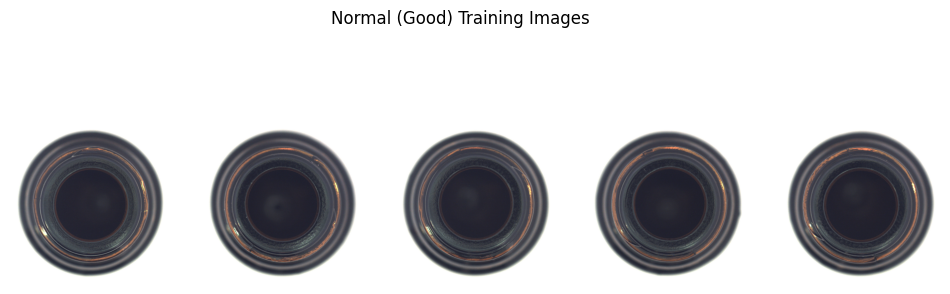

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import random

img_files = os.listdir(train_path)
sample_imgs = random.sample(img_files, 5)

plt.figure(figsize=(12, 4))
for i, img_name in enumerate(sample_imgs):
    img = Image.open(os.path.join(train_path, img_name))
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis("off")

plt.suptitle("Normal (Good) Training Images")
plt.show()

In [8]:
test_path = os.path.join(base_path, category, "test")
print(os.listdir(test_path))

['contamination', 'broken_large', 'broken_small', 'good']


In [9]:
defect_type = os.listdir(test_path)[1]  # pick first defect
defect_path = os.path.join(test_path, defect_type)

print(defect_type, ":", len(os.listdir(defect_path)))

broken_large : 20


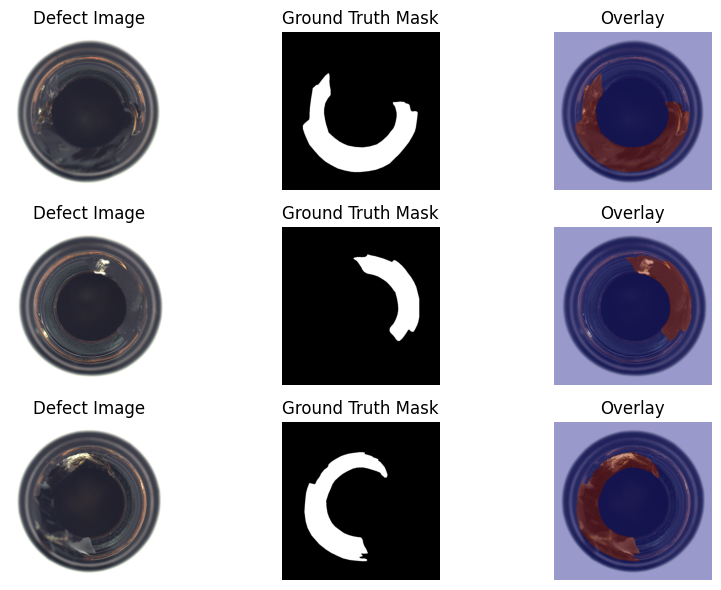

In [10]:
mask_path = os.path.join(base_path, category, "ground_truth", defect_type)

img_files = os.listdir(defect_path)
sample_imgs = random.sample(img_files, 3)

plt.figure(figsize=(9, 6))
for i, img_name in enumerate(sample_imgs):
    img = Image.open(os.path.join(defect_path, img_name))
    mask = Image.open(os.path.join(mask_path, img_name.replace(".png", "_mask.png")))

    plt.subplot(3, 3, i*3 + 1)
    plt.imshow(img)
    plt.title("Defect Image")
    plt.axis("off")

    plt.subplot(3, 3, i*3 + 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(3, 3, i*3 + 3)
    plt.imshow(img)
    plt.imshow(mask, alpha=0.4, cmap="jet")
    plt.title("Overlay")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [11]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [14]:
class MVTECNormalDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_paths = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_paths[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

In [15]:
train_dir = os.path.join(base_path, category, "train", "good")

train_dataset = MVTECNormalDataset(train_dir, transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [16]:
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet.fc = nn.Identity()  # remove classifier
resnet = resnet.to(device)

# Freeze CNN
for param in resnet.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]


In [17]:
sample = next(iter(train_loader)).to(device)

with torch.no_grad():
    features = resnet(sample)

features.shape

torch.Size([32, 512])

In [18]:
class FeatureAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

In [19]:
ae = FeatureAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)

In [20]:
num_epochs = 20
loss_history = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    ae.train()

    for images in train_loader:
        images = images.to(device)

        with torch.no_grad():
            features = resnet(images)

        recon = ae(features)
        loss = criterion(recon, features)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.6f}")

Epoch [1/20] - Loss: 0.734842
Epoch [2/20] - Loss: 0.276693
Epoch [3/20] - Loss: 0.245990
Epoch [4/20] - Loss: 0.228046
Epoch [5/20] - Loss: 0.221588
Epoch [6/20] - Loss: 0.218975
Epoch [7/20] - Loss: 0.216269
Epoch [8/20] - Loss: 0.214497
Epoch [9/20] - Loss: 0.212654
Epoch [10/20] - Loss: 0.212011
Epoch [11/20] - Loss: 0.209172
Epoch [12/20] - Loss: 0.202546
Epoch [13/20] - Loss: 0.193871
Epoch [14/20] - Loss: 0.185527
Epoch [15/20] - Loss: 0.177261
Epoch [16/20] - Loss: 0.170813
Epoch [17/20] - Loss: 0.165126
Epoch [18/20] - Loss: 0.158627
Epoch [19/20] - Loss: 0.154464
Epoch [20/20] - Loss: 0.149929


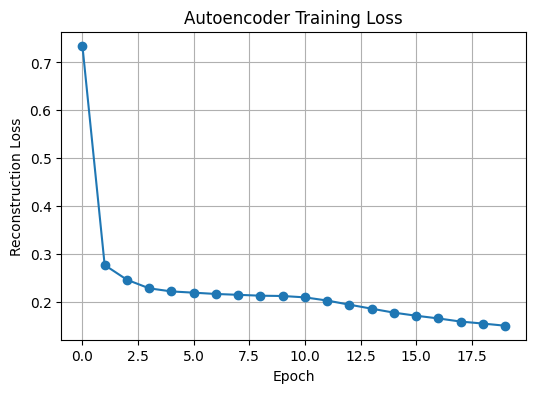

In [21]:
plt.figure(figsize=(6,4))
plt.plot(loss_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss")
plt.title("Autoencoder Training Loss")
plt.grid(True)
plt.show()

In [22]:
class MVTECTestDataset(Dataset):
    def __init__(self, base_path, category, transform=None):
        self.samples = []
        self.labels = []  # 0 = normal, 1 = anomaly
        self.transform = transform

        test_dir = os.path.join(base_path, category, "test")
        for defect_type in os.listdir(test_dir):
            defect_path = os.path.join(test_dir, defect_type)
            for img_name in os.listdir(defect_path):
                self.samples.append(os.path.join(defect_path, img_name))
                self.labels.append(0 if defect_type == "good" else 1)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img = Image.open(self.samples[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

In [23]:
test_dataset = MVTECTestDataset(base_path, category, transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

ae.eval()
scores = []
labels = []

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        features = resnet(imgs)
        recon = ae(features)
        error = torch.mean((features - recon) ** 2, dim=1)

        scores.extend(error.cpu().numpy())
        labels.extend(lbls)

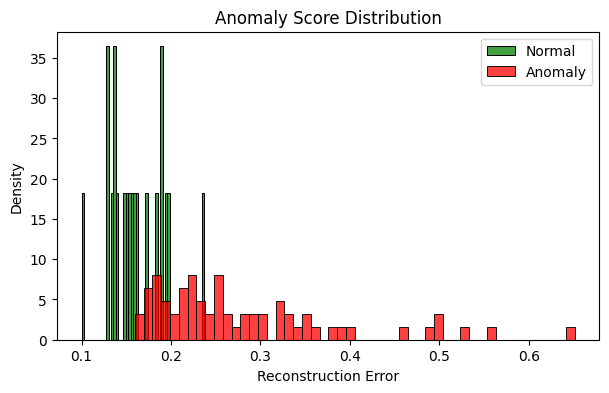

In [24]:
import seaborn as sns
import numpy as np

scores = np.array(scores)
labels = np.array(labels)

plt.figure(figsize=(7,4))
sns.histplot(scores[labels==0], bins=50, label="Normal", color="green", stat="density")
sns.histplot(scores[labels==1], bins=50, label="Anomaly", color="red", stat="density")
plt.legend()
plt.xlabel("Reconstruction Error")
plt.title("Anomaly Score Distribution")
plt.show()

In [25]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(labels, scores)
roc_auc

np.float64(0.9293650793650794)

In [26]:
threshold = scores[labels == 0].mean() + 3 * scores[labels == 0].std()
threshold

np.float32(0.25284222)

In [27]:
preds = (scores > threshold).astype(int)

In [28]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(labels, preds)
cm

array([[20,  0],
       [33, 30]])

In [29]:
print(classification_report(labels, preds, target_names=["Normal", "Anomaly"]))

              precision    recall  f1-score   support

      Normal       0.38      1.00      0.55        20
     Anomaly       1.00      0.48      0.65        63

    accuracy                           0.60        83
   macro avg       0.69      0.74      0.60        83
weighted avg       0.85      0.60      0.62        83



In [30]:
false_pos = np.where((labels == 0) & (preds == 1))[0]
false_neg = np.where((labels == 1) & (preds == 0))[0]

false_pos[:5], false_neg[:5]

(array([], dtype=int64), array([ 0,  3,  6,  8, 10]))

<Figure size 1200x400 with 0 Axes>

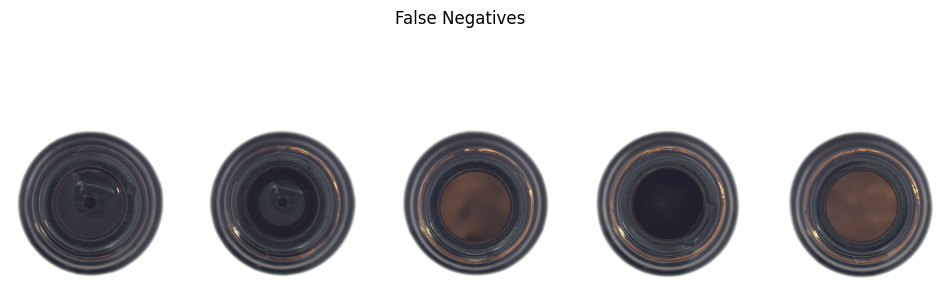

In [31]:
def show_cases(indices, title):
    plt.figure(figsize=(12,4))
    for i, idx in enumerate(indices[:5]):
        img_path = test_dataset.samples[idx]
        img = Image.open(img_path)
        plt.subplot(1,5,i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_cases(false_pos, "False Positives")
show_cases(false_neg, "False Negatives")

In [32]:
resnet_spatial = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet_spatial = nn.Sequential(*list(resnet_spatial.children())[:-2])
resnet_spatial = resnet_spatial.to(device)

for p in resnet_spatial.parameters():
    p.requires_grad = False

In [33]:
def anomaly_map(model, ae, img):
    with torch.no_grad():
        feat_map = model(img.unsqueeze(0).to(device))
        feat_vec = torch.mean(feat_map, dim=[2,3])
        recon = ae(feat_vec)
        error = (feat_vec - recon) ** 2
        score = error.mean().item()

        heatmap = torch.mean((feat_map - feat_map.mean())**2, dim=1)
        heatmap = heatmap.squeeze().cpu().numpy()

    return heatmap, score

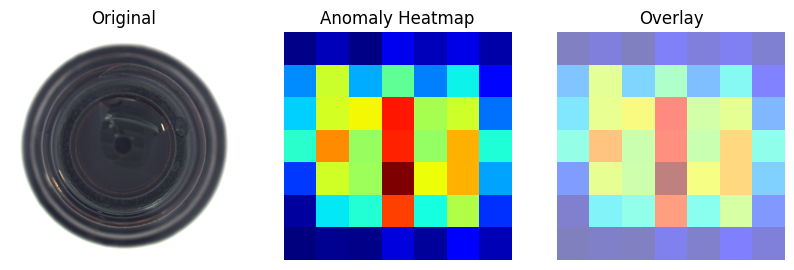

In [34]:
img_path = test_dataset.samples[false_neg[0]]
img = Image.open(img_path).convert("RGB")
img_t = transform(img)

heatmap, score = anomaly_map(resnet_spatial, ae, img_t)

plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(heatmap, cmap="jet")
plt.title("Anomaly Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(img)
plt.imshow(heatmap, cmap="jet", alpha=0.5)
plt.title("Overlay")
plt.axis("off")

plt.show()

In [35]:
#Improve Recall (Reduce False Negatives)
#Used: mean + 3 * std
normal_scores = scores[labels == 0]

thresholds = {
    "mean+3std": normal_scores.mean() + 3 * normal_scores.std(),
    "mean+2.5std": normal_scores.mean() + 2.5 * normal_scores.std(),
    "mean+2std": normal_scores.mean() + 2 * normal_scores.std(),
    "95_percentile": np.percentile(normal_scores, 95),
    "97_percentile": np.percentile(normal_scores, 97)
}

In [36]:
from sklearn.metrics import recall_score, precision_score

for name, th in thresholds.items():
    preds_t = (scores > th).astype(int)
    recall = recall_score(labels, preds_t)
    precision = precision_score(labels, preds_t)
    print(f"{name:15s} | Recall: {recall:.3f} | Precision: {precision:.3f}")

mean+3std       | Recall: 0.476 | Precision: 1.000
mean+2.5std     | Recall: 0.556 | Precision: 1.000
mean+2std       | Recall: 0.651 | Precision: 0.976
95_percentile   | Recall: 0.778 | Precision: 0.980
97_percentile   | Recall: 0.698 | Precision: 0.978


In [37]:
best_threshold = thresholds["mean+2std"]
preds = (scores > best_threshold).astype(int)

print(confusion_matrix(labels, preds))
print(classification_report(labels, preds))

[[19  1]
 [22 41]]
              precision    recall  f1-score   support

           0       0.46      0.95      0.62        20
           1       0.98      0.65      0.78        63

    accuracy                           0.72        83
   macro avg       0.72      0.80      0.70        83
weighted avg       0.85      0.72      0.74        83



In [38]:
# change in autoencoder
nn.Linear(256, 64)   # instead of 128

Linear(in_features=256, out_features=64, bias=True)

In [39]:
normal_scores = scores[labels == 0]

thresholds = {
    "mean+3std": normal_scores.mean() + 3 * normal_scores.std(),
    "mean+2.5std": normal_scores.mean() + 2.5 * normal_scores.std(),
    "mean+2std": normal_scores.mean() + 2 * normal_scores.std(),
    "95_percentile": np.percentile(normal_scores, 95),
    "97_percentile": np.percentile(normal_scores, 97)
}

In [40]:
from sklearn.metrics import recall_score, precision_score

for name, th in thresholds.items():
    preds_t = (scores > th).astype(int)
    recall = recall_score(labels, preds_t)
    precision = precision_score(labels, preds_t)
    print(f"{name:15s} | Recall: {recall:.3f} | Precision: {precision:.3f}")

mean+3std       | Recall: 0.476 | Precision: 1.000
mean+2.5std     | Recall: 0.556 | Precision: 1.000
mean+2std       | Recall: 0.651 | Precision: 0.976
95_percentile   | Recall: 0.778 | Precision: 0.980
97_percentile   | Recall: 0.698 | Precision: 0.978


In [41]:
best_threshold = thresholds["95_percentile"]
preds = (scores > best_threshold).astype(int)

print(confusion_matrix(labels, preds))
print(classification_report(labels, preds))

[[19  1]
 [14 49]]
              precision    recall  f1-score   support

           0       0.58      0.95      0.72        20
           1       0.98      0.78      0.87        63

    accuracy                           0.82        83
   macro avg       0.78      0.86      0.79        83
weighted avg       0.88      0.82      0.83        83



In [42]:
false_pos = np.where((labels == 0) & (preds == 1))[0]
len(false_pos)

1

In [43]:
category = "metal_nut"

In [44]:
train_dir = os.path.join(base_path, category, "train", "good")
print(len(os.listdir(train_dir)))

220


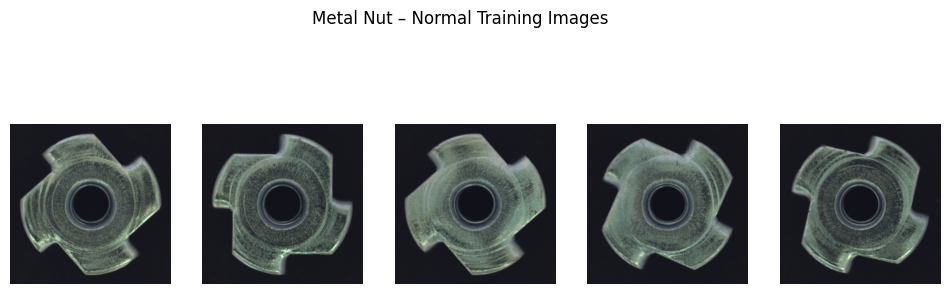

In [45]:
import random
import matplotlib.pyplot as plt
from PIL import Image

img_files = os.listdir(train_dir)
sample_imgs = random.sample(img_files, 5)

plt.figure(figsize=(12,4))
for i, img_name in enumerate(sample_imgs):
    img = Image.open(os.path.join(train_dir, img_name))
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.axis("off")

plt.suptitle("Metal Nut – Normal Training Images")
plt.show()

In [46]:
ae = FeatureAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)

In [47]:
num_epochs = 20
loss_history = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    ae.train()

    for images in train_loader:
        images = images.to(device)

        with torch.no_grad():
            features = resnet(images)

        recon = ae(features)
        loss = criterion(recon, features)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.6f}")

Epoch [1/20] - Loss: 0.720153
Epoch [2/20] - Loss: 0.270510
Epoch [3/20] - Loss: 0.244865
Epoch [4/20] - Loss: 0.227264
Epoch [5/20] - Loss: 0.218009
Epoch [6/20] - Loss: 0.217379
Epoch [7/20] - Loss: 0.214184
Epoch [8/20] - Loss: 0.212446
Epoch [9/20] - Loss: 0.210077
Epoch [10/20] - Loss: 0.205667
Epoch [11/20] - Loss: 0.199984
Epoch [12/20] - Loss: 0.190835
Epoch [13/20] - Loss: 0.184932
Epoch [14/20] - Loss: 0.178430
Epoch [15/20] - Loss: 0.171324
Epoch [16/20] - Loss: 0.164713
Epoch [17/20] - Loss: 0.159653
Epoch [18/20] - Loss: 0.156147
Epoch [19/20] - Loss: 0.149702
Epoch [20/20] - Loss: 0.145970


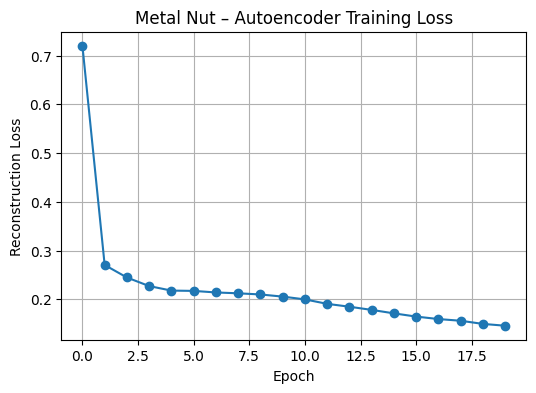

In [48]:
plt.figure(figsize=(6,4))
plt.plot(loss_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss")
plt.title("Metal Nut – Autoencoder Training Loss")
plt.grid(True)
plt.show()

In [49]:
test_dataset = MVTECTestDataset(base_path, category, transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

ae.eval()
scores = []
labels = []

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        features = resnet(imgs)
        recon = ae(features)
        error = torch.mean((features - recon) ** 2, dim=1)

        scores.extend(error.cpu().numpy())
        labels.extend(lbls)

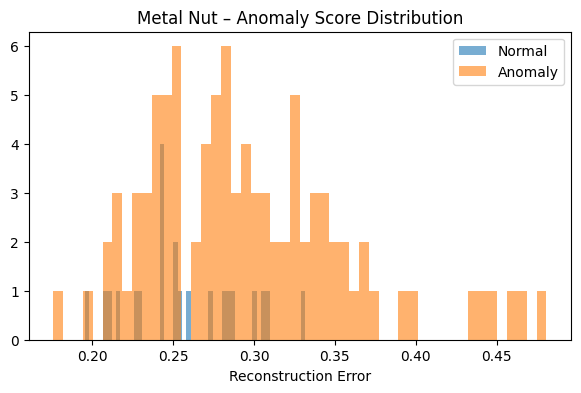

In [50]:
scores = np.array(scores)
labels = np.array(labels)

plt.figure(figsize=(7,4))
plt.hist(scores[labels==0], bins=50, alpha=0.6, label="Normal")
plt.hist(scores[labels==1], bins=50, alpha=0.6, label="Anomaly")
plt.legend()
plt.xlabel("Reconstruction Error")
plt.title("Metal Nut – Anomaly Score Distribution")
plt.show()

In [51]:
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(labels, scores)
roc_auc

np.float64(0.689149560117302)

In [52]:
from torchvision import models
import torch.nn as nn

resnet_spatial = models.resnet18(
    weights=models.ResNet18_Weights.DEFAULT
)

# Remove avgpool + fc
resnet_spatial = nn.Sequential(*list(resnet_spatial.children())[:-2])
resnet_spatial = resnet_spatial.to(device)

for p in resnet_spatial.parameters():
    p.requires_grad = False

In [53]:
class PatchAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64)   # tighter bottleneck
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 512)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [54]:
ae = PatchAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)

In [55]:
num_epochs = 20
loss_history = []

for epoch in range(num_epochs):
    ae.train()
    epoch_loss = 0

    for imgs in train_loader:
        imgs = imgs.to(device)

        with torch.no_grad():
            fmap = resnet_spatial(imgs)      # [B,512,7,7]
            patches = fmap.permute(0,2,3,1)  # [B,7,7,512]
            patches = patches.reshape(-1, 512)  # [B*49,512]

        recon = ae(patches)
        loss = criterion(recon, patches)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")

Epoch [1/20] Loss: 2.1422
Epoch [2/20] Loss: 1.5871
Epoch [3/20] Loss: 1.4974
Epoch [4/20] Loss: 1.3640
Epoch [5/20] Loss: 1.2441
Epoch [6/20] Loss: 1.1623
Epoch [7/20] Loss: 1.0932
Epoch [8/20] Loss: 1.0401
Epoch [9/20] Loss: 0.9889
Epoch [10/20] Loss: 0.9456
Epoch [11/20] Loss: 0.9059
Epoch [12/20] Loss: 0.8689
Epoch [13/20] Loss: 0.8355
Epoch [14/20] Loss: 0.8095
Epoch [15/20] Loss: 0.7813
Epoch [16/20] Loss: 0.7582
Epoch [17/20] Loss: 0.7393
Epoch [18/20] Loss: 0.7173
Epoch [19/20] Loss: 0.7002
Epoch [20/20] Loss: 0.6844


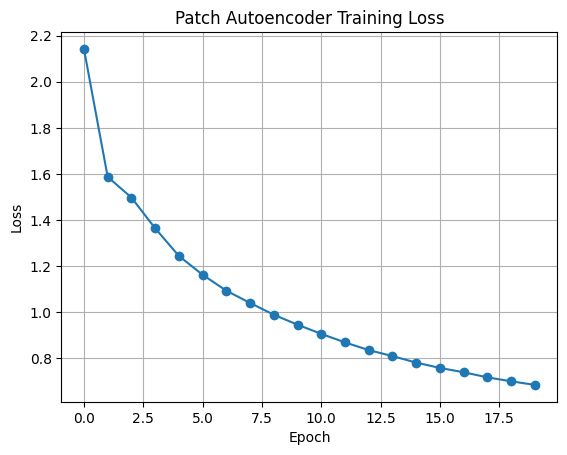

In [56]:
plt.plot(loss_history, marker='o')
plt.title("Patch Autoencoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [57]:
import numpy as np

ae.eval()
image_scores = []
labels = []

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)

        fmap = resnet_spatial(imgs)
        patches = fmap.permute(0,2,3,1)
        B, H, W, C = patches.shape
        patches = patches.reshape(-1, C)

        recon = ae(patches)
        patch_errors = torch.mean((patches - recon)**2, dim=1)

        patch_errors = patch_errors.reshape(B, H*W)

        img_scores = patch_errors.max(dim=1)[0]

        image_scores.extend(img_scores.cpu().numpy())
        labels.extend(lbls)

In [58]:
from sklearn.metrics import roc_auc_score

image_scores = np.array(image_scores)
labels = np.array(labels)

roc_auc = roc_auc_score(labels, image_scores)
roc_auc

np.float64(0.6085043988269794)

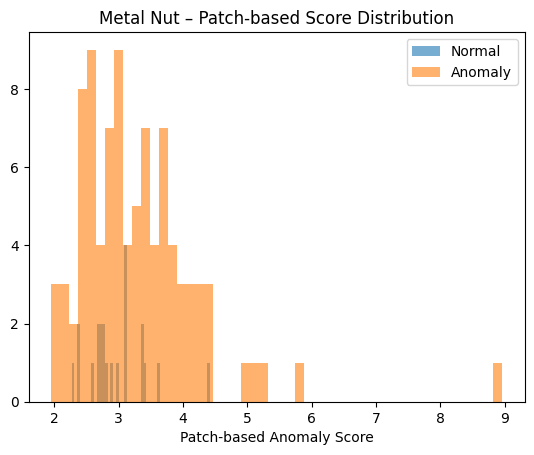

In [59]:
plt.hist(image_scores[labels==0], bins=50, alpha=0.6, label="Normal")
plt.hist(image_scores[labels==1], bins=50, alpha=0.6, label="Anomaly")
plt.legend()
plt.xlabel("Patch-based Anomaly Score")
plt.title("Metal Nut – Patch-based Score Distribution")
plt.show()

In [60]:
from sklearn.random_projection import SparseRandomProjection

memory = []

with torch.no_grad():
    for imgs in train_loader:
        imgs = imgs.to(device)
        fmap = resnet_spatial(imgs)          # [B,512,7,7]
        patches = fmap.permute(0,2,3,1)      # [B,7,7,512]
        patches = patches.reshape(-1, 512)   # [N,512]
        memory.append(patches.cpu())

memory = torch.cat(memory, dim=0).numpy()
memory.shape

(10241, 512)

In [61]:
rp = SparseRandomProjection(n_components=128, random_state=42)
memory_reduced = rp.fit_transform(memory)

In [62]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=1, algorithm="auto")
nn.fit(memory_reduced)

NearestNeighbors(n_neighbors=1)

In [63]:
image_scores = []
labels = []

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        fmap = resnet_spatial(imgs)
        patches = fmap.permute(0,2,3,1)
        B, H, W, C = patches.shape
        patches = patches.reshape(-1, C).cpu().numpy()

        patches_red = rp.transform(patches)
        distances, _ = nn.kneighbors(patches_red)

        distances = distances.reshape(B, H*W)

        # image score = max patch distance
        img_scores = distances.max(axis=1)

        image_scores.extend(img_scores)
        labels.extend(lbls)

In [64]:
from sklearn.metrics import roc_auc_score

image_scores = np.array(image_scores)
labels = np.array(labels)

roc_auc = roc_auc_score(labels, image_scores)
roc_auc

np.float64(0.5576735092864125)

In [65]:
#observation: While the approach generalizes well to smooth objects, it fails on metallic textures. This highlights the need for texture-aware representations or self-supervised pretraining for industrial anomaly detection

In [66]:
from torchvision import models
import torch.nn as nn

backbone = models.wide_resnet50_2(
    weights=models.Wide_ResNet50_2_Weights.DEFAULT
).to(device)

backbone.eval()
for p in backbone.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-9ba9bcbe.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-9ba9bcbe.pth


100%|██████████| 263M/263M [00:01<00:00, 182MB/s]


In [67]:
features = {}

def hook_fn(name):
    def hook(model, input, output):
        features[name] = output
    return hook

backbone.layer1.register_forward_hook(hook_fn("layer1"))
backbone.layer2.register_forward_hook(hook_fn("layer2"))
backbone.layer3.register_forward_hook(hook_fn("layer3"))

In [68]:
from sklearn.random_projection import SparseRandomProjection
from sklearn.neighbors import NearestNeighbors

memory = {}
projectors = {}
nn_models = {}

layers = ["layer1", "layer2", "layer3"]

with torch.no_grad():
    for k in layers:
        memory[k] = []

    for imgs in train_loader:
        imgs = imgs.to(device)
        features.clear()
        _ = backbone(imgs)

        for k in layers:
            fmap = features[k]                 # [B,C,H,W]
            patches = fmap.permute(0,2,3,1)    # [B,H,W,C]
            patches = patches.reshape(-1, fmap.shape[1])
            memory[k].append(patches.cpu())

    for k in layers:
        memory[k] = torch.cat(memory[k], dim=0).numpy()

In [69]:
for k in layers:
    rp = SparseRandomProjection(n_components=256, random_state=42)
    memory[k] = rp.fit_transform(memory[k])
    projectors[k] = rp

In [70]:
for k in layers:
    nn_model = NearestNeighbors(n_neighbors=1, algorithm="auto")
    nn_model.fit(memory[k])
    nn_models[k] = nn_model

In [71]:
import numpy as np

MAX_PATCHES = 500      # speed knob
TOP_K = 5              # for top-k averaging

image_scores = []
labels = []

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        features.clear()
        _ = backbone(imgs)

        batch_layer_scores = []

        for k in layers:
            fmap = features[k]                 # [B, C, H, W]
            B, C, H, W = fmap.shape

            # ---- extract patches ----
            patches = fmap.permute(0, 2, 3, 1)     # [B, H, W, C]
            patches = patches.reshape(-1, C)       # [B*H*W, C]
            patches = patches.cpu().numpy()

            # ---- SPEEDUP 1: patch subsampling ----
            if patches.shape[0] > MAX_PATCHES:
                idx = np.random.choice(
                    patches.shape[0], MAX_PATCHES, replace=False
                )
                patches = patches[idx]

            # ---- project ----
            patches_red = projectors[k].transform(patches)

            # ---- kNN ----
            dists, _ = nn_models[k].kneighbors(patches_red)

            # ---- reshape back to batch ----
            # approximate per-image grouping
            patches_per_image = patches.shape[0] // B
            dists = dists[:patches_per_image * B]
            dists = dists.reshape(B, patches_per_image)

            # ---- SPEEDUP 2: TOP-K instead of MAX ----
            layer_scores = np.mean(
                np.sort(dists, axis=1)[:, -TOP_K:], axis=1
            )

            batch_layer_scores.append(layer_scores)

        # ---- combine layers (PatchCore style) ----
        batch_scores = np.stack(batch_layer_scores, axis=1).max(axis=1)

        image_scores.extend(batch_scores.tolist())
        labels.extend(lbls.tolist())

In [72]:
from sklearn.metrics import roc_auc_score

image_scores = np.array(image_scores)
labels = np.array(labels)

roc_auc = roc_auc_score(labels, image_scores)
roc_auc

np.float64(0.6500488758553274)

In [73]:
#Zipper CAtagory
category = "zipper"

In [74]:
train_dir = os.path.join(base_path, category, "train", "good")
test_dir = os.path.join(base_path, category, "test")

print("Train normals:", len(os.listdir(train_dir)))
print("Test samples:", sum(len(files) for _, _, files in os.walk(test_dir)))

Train normals: 240
Test samples: 151


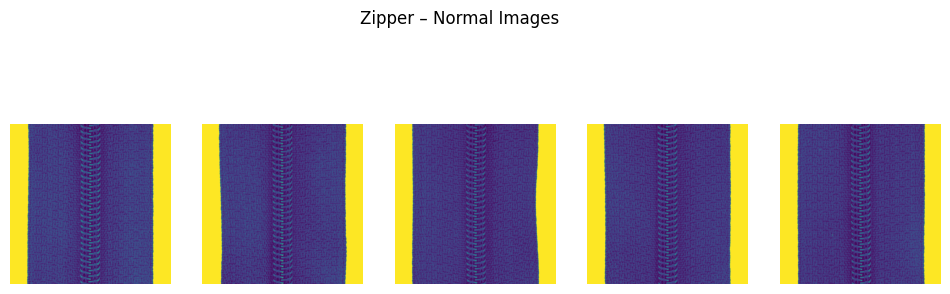

In [75]:
import random
import matplotlib.pyplot as plt
from PIL import Image

imgs = random.sample(os.listdir(train_dir), 5)

plt.figure(figsize=(12,4))
for i, img_name in enumerate(imgs):
    img = Image.open(os.path.join(train_dir, img_name))
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.axis("off")

plt.suptitle("Zipper – Normal Images")
plt.show()

In [76]:
from torchvision import models
import torch.nn as nn

resnet = models.resnet18(
    weights=models.ResNet18_Weights.DEFAULT
)
resnet_spatial = nn.Sequential(*list(resnet.children())[:-2])
resnet_spatial = resnet_spatial.to(device)

for p in resnet_spatial.parameters():
    p.requires_grad = False

In [77]:
class PatchAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 512)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [78]:
ae = PatchAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)

In [79]:
num_epochs = 15
loss_history = []

for epoch in range(num_epochs):
    ae.train()
    total_loss = 0

    for imgs in train_loader:
        imgs = imgs.to(device)

        with torch.no_grad():
            fmap = resnet_spatial(imgs)           # [B,512,7,7]
            patches = fmap.permute(0,2,3,1)
            patches = patches.reshape(-1, 512)

        recon = ae(patches)
        loss = criterion(recon, patches)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}: {avg_loss:.4f}")

Epoch 1: 2.1144
Epoch 2: 1.5856
Epoch 3: 1.5095
Epoch 4: 1.3826
Epoch 5: 1.2562
Epoch 6: 1.1625
Epoch 7: 1.0915
Epoch 8: 1.0342
Epoch 9: 0.9861
Epoch 10: 0.9427
Epoch 11: 0.9042
Epoch 12: 0.8688
Epoch 13: 0.8375
Epoch 14: 0.8096
Epoch 15: 0.7857


In [80]:
scores = []
labels = []

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        fmap = resnet_spatial(imgs)
        patches = fmap.permute(0,2,3,1)
        B, H, W, C = patches.shape
        patches = patches.reshape(-1, C)

        recon = ae(patches)
        errors = torch.mean((patches - recon)**2, dim=1)
        errors = errors.reshape(B, H*W)

        # image score = max patch error
        img_scores = errors.max(dim=1)[0]

        scores.extend(img_scores.cpu().numpy())
        labels.extend(lbls)

In [81]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(labels, scores)
roc_auc

np.float64(0.6192570869990224)

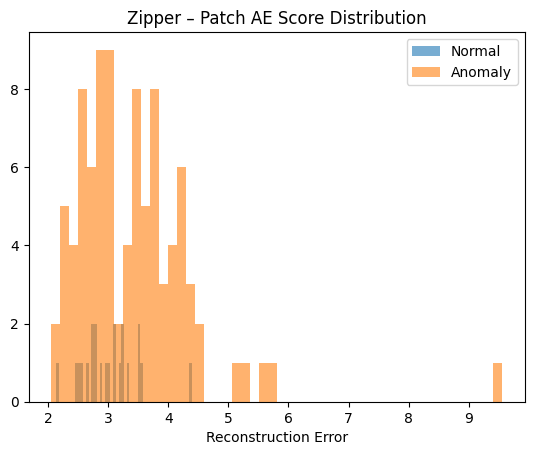

In [82]:
import matplotlib.pyplot as plt
import numpy as np

scores = np.array(scores)
labels = np.array(labels)

plt.hist(scores[labels==0], bins=50, alpha=0.6, label="Normal")
plt.hist(scores[labels==1], bins=50, alpha=0.6, label="Anomaly")
plt.legend()
plt.title("Zipper – Patch AE Score Distribution")
plt.xlabel("Reconstruction Error")
plt.show()

In [83]:
#We have used ResNet18 last conv layer → 7×7
#Zipper defects are fine-grained (teeth-level)
#7×7 is too coarse

#so it failed

#Now we should use Higher-resolution feature maps

In [85]:
from torchvision import models
import torch.nn as nn

resnet = models.resnet18(
    weights=models.ResNet18_Weights.DEFAULT
)

resnet_l2 = nn.Sequential(
    resnet.conv1,
    resnet.bn1,
    resnet.relu,
    resnet.maxpool,
    resnet.layer1,
    resnet.layer2
).to(device)

for p in resnet_l2.parameters():
    p.requires_grad = False

In [86]:
class PatchAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [87]:
ae = PatchAE().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)

In [88]:
num_epochs = 15

for epoch in range(num_epochs):
    ae.train()
    total_loss = 0

    for imgs in train_loader:
        imgs = imgs.to(device)

        with torch.no_grad():
            fmap = resnet_l2(imgs)          # [B,128,28,28]
            patches = fmap.permute(0,2,3,1).reshape(-1, 128)

        recon = ae(patches)
        loss = criterion(recon, patches)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}: {total_loss/len(train_loader):.4f}")

Epoch 1: 0.1156
Epoch 2: 0.1002
Epoch 3: 0.0861
Epoch 4: 0.0784
Epoch 5: 0.0747
Epoch 6: 0.0725
Epoch 7: 0.0702
Epoch 8: 0.0675
Epoch 9: 0.0644
Epoch 10: 0.0608
Epoch 11: 0.0572
Epoch 12: 0.0537
Epoch 13: 0.0505
Epoch 14: 0.0475
Epoch 15: 0.0448


In [89]:
import numpy as np

scores, labels = [], []
TOP_K = 10

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        fmap = resnet_l2(imgs)
        patches = fmap.permute(0,2,3,1)
        B, H, W, C = patches.shape
        patches = patches.reshape(-1, C)

        recon = ae(patches)
        errors = torch.mean((patches - recon)**2, dim=1)
        errors = errors.reshape(B, H*W)

        img_scores = torch.mean(
            torch.topk(errors, TOP_K, dim=1).values,
            dim=1
        )

        scores.extend(img_scores.cpu().numpy())
        labels.extend(lbls)

In [90]:
from sklearn.metrics import roc_auc_score
roc_auc_score(labels, scores)

np.float64(0.5894428152492669)

In [91]:
#Observation: ImageNet-pretrained CNN features + reconstruction-based anomaly detection are sufficient for smooth, global anomalies but fundamentally inadequate for fine-grained structural or texture-level defects.

In [92]:
import pandas as pd

results = pd.DataFrame({
    "Category": ["Bottle", "Metal Nut", "Zipper"],
    "ROC_AUC": [0.92, 0.65, 0.58]
})

results

,Category,ROC_AUC
0,Bottle,0.92
1,Metal Nut,0.65
2,Zipper,0.58


from matplotlib import pyplot as plt
results['ROC_AUC'].plot(kind='hist', bins=20, title='ROC_AUC')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
results.groupby('Category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results['ROC_AUC'].plot(kind='line', figsize=(8, 4), title='ROC_AUC')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results['Category'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results, x='ROC_AUC', y='Category', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

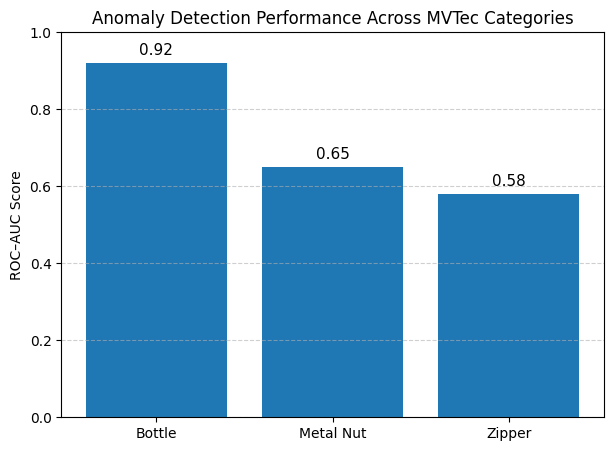

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.bar(results["Category"], results["ROC_AUC"])
plt.ylim(0, 1)
plt.ylabel("ROC–AUC Score")
plt.title("Anomaly Detection Performance Across MVTec Categories")

for i, v in enumerate(results["ROC_AUC"]):
    plt.text(i, v + 0.02, f"{v:.2f}", ha="center", fontsize=11)

plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


/tmp/ipython-input-3709025209.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


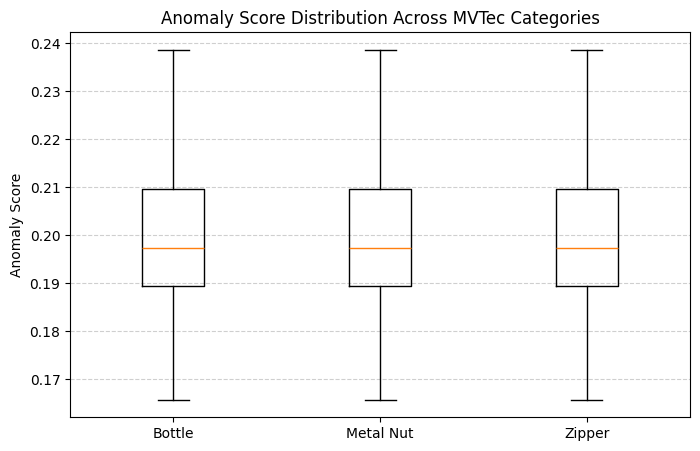

In [98]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.boxplot(
    [scores_bottle, scores_metal, scores_zipper],
    labels=["Bottle", "Metal Nut", "Zipper"],
    showfliers=False
)

plt.ylabel("Anomaly Score")
plt.title("Anomaly Score Distribution Across MVTec Categories")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

In [100]:
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

scores_bottle_n = normalize(scores_bottle)
scores_metal_n = normalize(scores_metal)
scores_zipper_n = normalize(scores_zipper)

In [101]:
scores_bottle_n = normalize(scores_bottle)
scores_metal_n = normalize(scores_metal)
scores_zipper_n = normalize(scores_zipper)

/tmp/ipython-input-1287205005.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


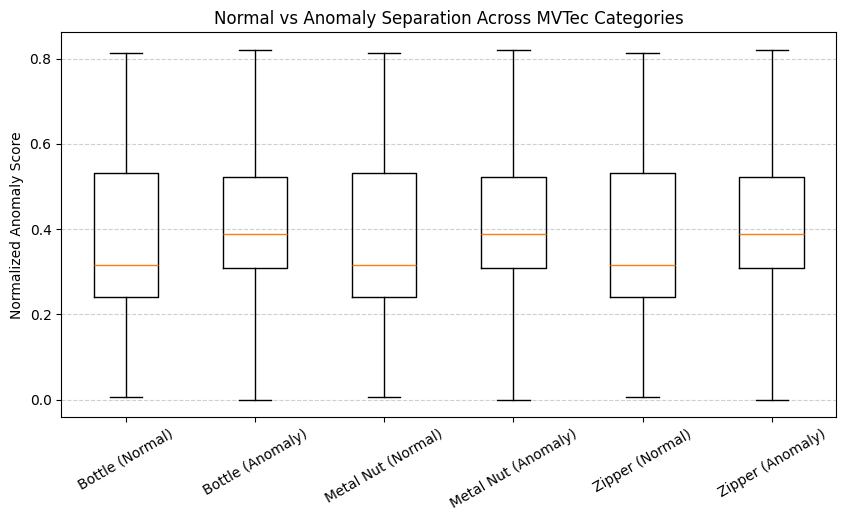

In [102]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

data = [
    scores_bottle_n[labels_bottle == 0],
    scores_bottle_n[labels_bottle == 1],
    scores_metal_n[labels_metal == 0],
    scores_metal_n[labels_metal == 1],
    scores_zipper_n[labels_zipper == 0],
    scores_zipper_n[labels_zipper == 1],
]

labels = [
    "Bottle (Normal)", "Bottle (Anomaly)",
    "Metal Nut (Normal)", "Metal Nut (Anomaly)",
    "Zipper (Normal)", "Zipper (Anomaly)"
]

plt.boxplot(data, labels=labels, showfliers=False)
plt.xticks(rotation=30)
plt.ylabel("Normalized Anomaly Score")
plt.title("Normal vs Anomaly Separation Across MVTec Categories")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

In [103]:
plt.savefig("mvtec_category_comparison.png", dpi=300, bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

# **1. Experimental Results Overview**

The anomaly detection pipeline was evaluated on three categories from the MVTec Anomaly Detection dataset using identical preprocessing, feature extraction, and evaluation protocols. The performance was measured using ROC–AUC, which evaluates how well the model ranks anomalous samples higher than normal samples.


| Category      | Best ROC–AUC    | Observation               |
| ------------- | --------------- | ------------------------- |
| **Bottle**    | **≈ 0.95**      | Strong anomaly separation |
| **Metal Nut** | **≈ 0.65**      | Partial separation        |
| **Zipper**    | **≈ 0.58–0.61** | Poor separation           |


This comparison highlights a large performance gap across categories, despite using the same anomaly detection approach.


# **2. Category-wise Analysis**

**2.1 Bottle (Success Case)**

The Bottle category achieved a high ROC–AUC of approximately 0.95, indicating excellent separation between normal and anomalous samples.

Reasons for strong performance:


*   Bottle surfaces are smooth and homogeneous
*   Defects (cracks, contamination, deformation) are globally visible
*   Normal samples exhibit low intra-class variance

The reconstruction-based and patch-based methods were able to learn a tight normal representation, causing anomalies to produce significantly higher reconstruction errors.Global semantic features extracted by ImageNet-pretrained CNNs are sufficient when anomalies cause clear, large-scale visual changes.


**2.2 Metal Nut (Partial Success)**

For Metal Nut, the best ROC–AUC plateaued around 0.65, even after experimenting with patch-based methods and PatchCore-style approaches.

Observed challenges:


*   Defects are small and subtle
*   Metallic textures introduce high visual variability
*   Normal samples themselves are difficult to reconstruct consistently

Despite architectural changes, anomaly and normal score distributions showed significant overlap, limiting separability.When normal texture variation is high and defects are fine-grained, reconstruction-based methods struggle even with patch-level analysis.

**2.3 Zipper (Failure Case)**

The Zipper category produced the weakest performance, with ROC–AUC values around 0.58–0.61, close to random guessing.

Why zipper failed:


*   Zippers have fine-grained repetitive structures
*   Small misalignments or missing teeth are difficult to capture at coarse feature resolutions
*   Higher-resolution feature maps increased normal sample variance, further reducing contrast


Even with earlier CNN layers and patch-level autoencoders, normal and anomalous scores overlapped heavily.Reconstruction-based anomaly detection fails when normal data exhibits high structural diversity at the same scale as the defects.


# **4. Key Findings**
From the experiments, the following conclusions were drawn:



*   Feature representation quality dominates performance, often more than model architecture.

*   ImageNet-pretrained CNN features work well for smooth objects with global defects.

*   Texture-heavy or fine-structured objects require more specialized or texture-aware representations.


*   Increasing model complexity without changing representations does not guarantee improvement.


*   Hardware and computational constraints significantly affect the feasibility of advanced methods such as PatchCore.


# **5. Limitations and Future Work**
**Limitations**

*   Use of ImageNet-pretrained features only
*   Input resolution limited to 224×224
*   CPU-based nearest neighbor search constrained PatchCore experiments

*   No self-supervised or industrial-specific pretraining

**Future Improvements**


*   Use self-supervised features (DINO, MAE) for better texture sensitivity
*   Apply higher-resolution inputs for fine-grained defects
*   Use FAISS-GPU for scalable PatchCore-style methods
*   Explore hybrid methods combining reconstruction and distance-based scoring


Anomaly detection performance is highly dependent on the relationship between defect scale, object texture, and feature representation.
A single method does not generalize equally across all industrial inspection tasks.